In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import os
import numpy as np
from pathlib import Path
import pickle

import matplotlib as mpl

mpl.rcParams.update({"figure.facecolor": "white"})

In [25]:
use_sim_data = True
use_rmse = False

In [26]:
home = str(Path.home())
load_dir = home + r'\OneDrive - UCB-O365\ARSENL\Experiments\SPCM\evaluation_loss'
df_dtime = pd.read_csv(load_dir + r'/eval_loss_dtimeTrue_Rho1.0E+06-1.0E+10_order7-19_shots1.00E+05_use_final_True.csv')
df_pois = pd.read_csv(load_dir + r'/eval_loss_dtimeFalse_Rho1.0E+06-1.0E+10_order7-19_shots1.00E+05_use_final_True.csv')

if use_sim_data:
    df_dtime_fit = pd.read_csv(load_dir + r'/eval_loss_dtimeTrue_Rho1.0E+06-1.0E+10_order5-21_shots1.00E+06_best_fit.csv')
    df_pois_fit = pd.read_csv(load_dir + r'/eval_loss_dtimeFalse_Rho1.0E+06-1.0E+10_order5-21_shots1.00E+06_best_fit.csv')
    t = df_dtime_fit['time vector'].to_numpy()
    
    if use_rmse:
        rho_lst = []
        col_lst = []
        for col in df_dtime_fit:
            col_lst.append(col)
            rho_lst.append(col[3:])
        rho_lst = np.array(rho_lst[2:]).astype(float)

        true_rho_lst = []
        for i in range(len(rho_lst)):
            A = rho_lst[i]
            mu = 31.2e-9  # [s]
            sig = 500e-12  # [s]
            bg = 1e4  # [Hz]

            true_rho = A * np.exp(-1 * (t - mu) ** 2 / 2 / sig ** 2) + bg
            true_rho_lst.append(true_rho)

        RMSE_dtime_lst = np.zeros(len(true_rho_lst))
        RMSE_pois_lst = np.zeros(len(true_rho_lst))
        RRMSE_dtime_lst = np.zeros(len(true_rho_lst))
        RRMSE_pois_lst = np.zeros(len(true_rho_lst))
        for i in range(len(true_rho_lst)):
            true_rho = true_rho_lst[i]

            fit_rate_seg_dtime = df_dtime_fit[col_lst[i+2]]
            fit_rate_seg_pois = df_pois_fit[col_lst[i+2]]

            RMSE_dtime = np.sqrt(np.sum(((fit_rate_seg_dtime-true_rho))**2)/len(fit_rate_seg_dtime))
            RMSE_dtime_lst[i] = RMSE_dtime
            RRMSE_dtime = np.sqrt(np.sum(((fit_rate_seg_dtime-true_rho)/true_rho)**2)/len(fit_rate_seg_dtime))
            RRMSE_dtime_lst[i] = RRMSE_dtime

            RMSE_pois = np.sqrt(np.sum(((fit_rate_seg_pois-true_rho))**2)/len(fit_rate_seg_pois))
            RMSE_pois_lst[i] = RMSE_pois
            RRMSE_pois = np.sqrt(np.sum(((fit_rate_seg_pois-true_rho)/true_rho)**2)/len(fit_rate_seg_pois))
            RRMSE_pois_lst[i] = RRMSE_pois
    
eval_loss_dtime = df_dtime['Evaluation Loss'].dropna()
eval_loss_pois = df_pois['Evaluation Loss'].dropna()
percent_active = df_dtime['Average %-age where Detector was Active'].dropna()
optimal_C = df_dtime['Optimal Scaling Factor'].dropna()
if use_sim_data:
    rho_dtime = df_dtime['Rho']
    rho_pois = df_pois['Rho']
else:
    OD = df_dtime['OD'][:-1]
    transmit_factor = 10**(-OD)
    eval_loss_dtime = eval_loss_dtime[:-1]
    eval_loss_pois = eval_loss_pois[:-1]
    percent_active = percent_active[:-1]

# Plot Evaluation Loss vs OD

In [27]:
if use_sim_data:
    if not use_rmse:
        sort_idx = np.argsort(rho_dtime.to_numpy())
        eval_loss_dtime = eval_loss_dtime[sort_idx]
        eval_loss_pois = eval_loss_pois[sort_idx]
        rho_dtime = rho_dtime[sort_idx]
        rho_pois = rho_pois[sort_idx]

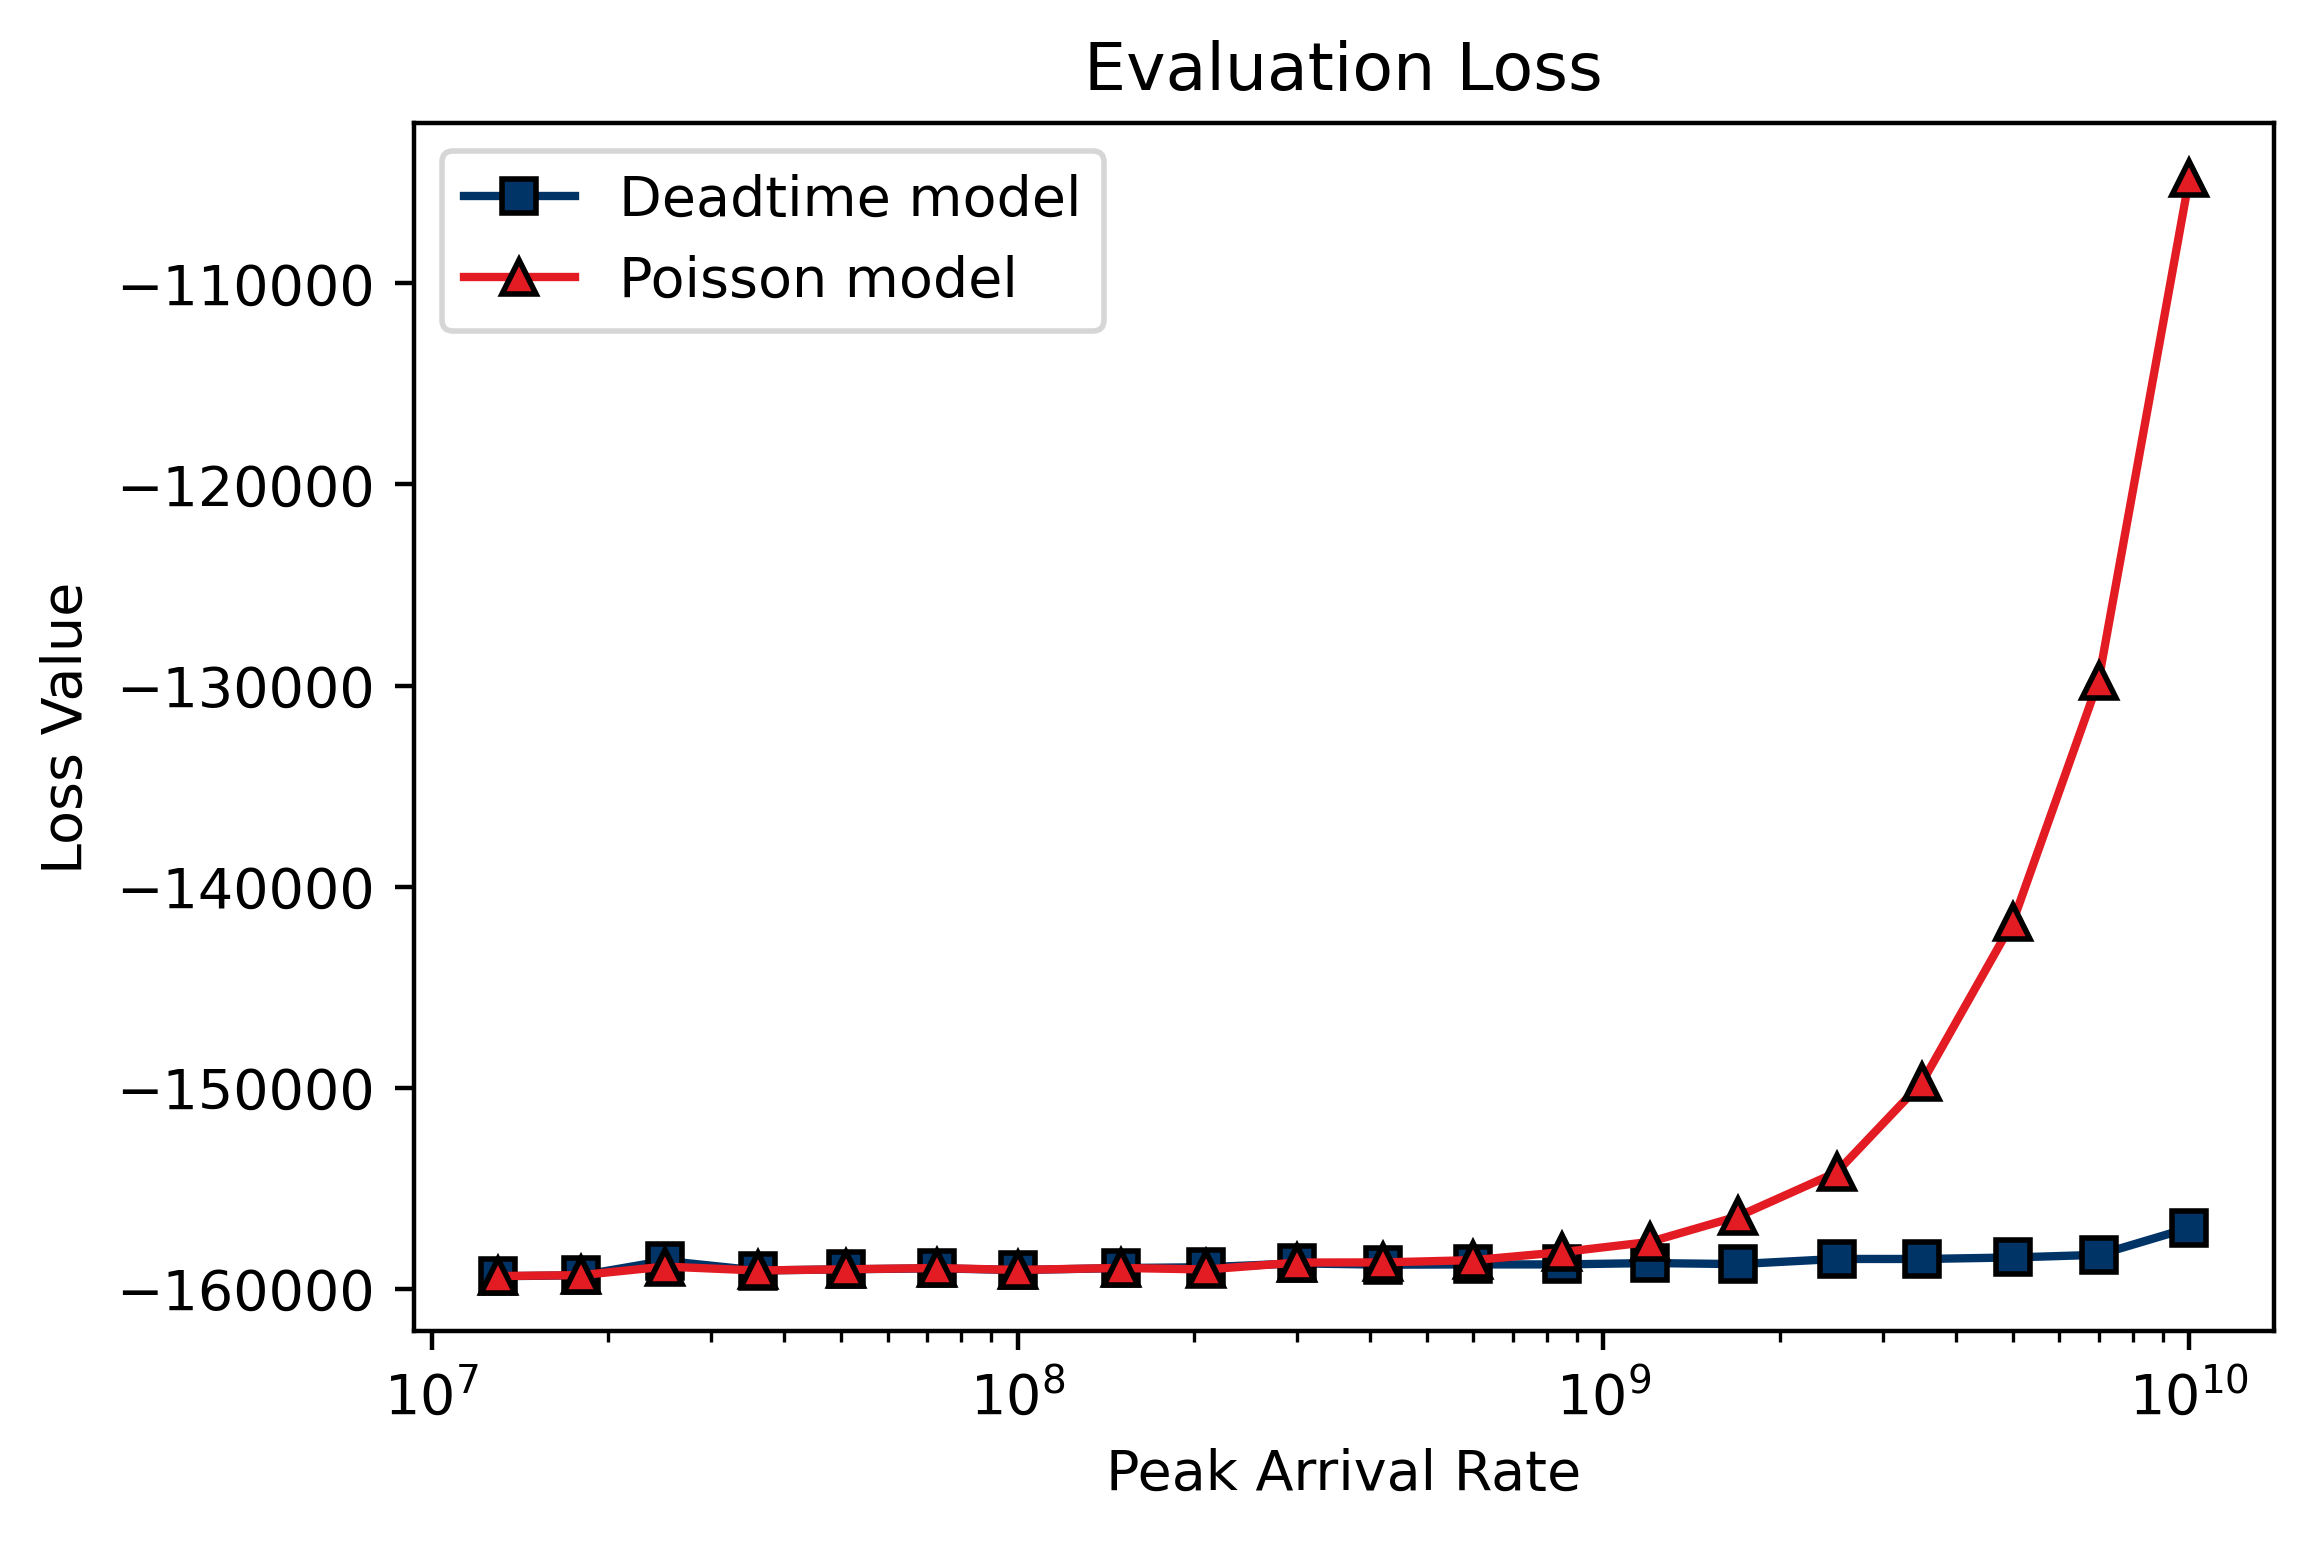

In [28]:
fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)
if use_sim_data:
    if use_rmse:
        ax.plot(rho_dtime, RMSE_dtime_lst, 's', color='#003366', markeredgecolor='black', label='Deadtime model')
        ax.plot(rho_pois, RMSE_pois_lst, '^', color='#E31B23', markeredgecolor='black', label='Poisson model')
        ax.set_ylabel('RMSE') 
        ax.set_yscale('log')
        plt.legend()
    else:
        ax.plot(rho_dtime, eval_loss_dtime, 's-', color='#003366', markeredgecolor='black', label='Deadtime model')
        ax.plot(rho_pois, eval_loss_pois, '^-', color='#E31B23', markeredgecolor='black', label='Poisson model')
#         ax.plot(rho_pois, eval_loss_pois - eval_loss_dtime, '.')
        ax.set_ylabel('Loss Value')
        ax.set_title('Evaluation Loss')
        plt.legend()
    ax.set_xlabel('Peak Arrival Rate')    
else:
    transmit_factor = 10**(-OD)
    atten_factor = 1-transmit_factor
    
    skip_num = 0
    ax.plot(transmit_factor[skip_num:], eval_loss_dtime[skip_num:], 's-', color='#003366', markeredgecolor='black', label='Deadtime model')
    ax.plot(transmit_factor[skip_num:], eval_loss_pois[skip_num:], '^-', color='#E31B23', markeredgecolor='black', label='Poisson model')
    ax.set_xlabel('Optical Transmission')
    ax.set_ylabel('Evaluation Loss')
    plt.legend()

plt.xscale('log')
# plt.xlim([10**7, 10**9])
# plt.ylim([-160000, -159000])


save_dir = home + r'/Downloads'
save_plt_file = r'/eval_loss_comparison.png'
fig.savefig(save_dir + save_plt_file)
plt.show()

In [ ]:
plt.plot(RMSE_dtime_lst, eval_loss_dtime, '.', label='deadtime')
# plt.plot(RMSE_pois_lst, eval_loss_pois, '.', label='poisson')
plt.xlabel('RMSE')
plt.ylabel('Evaluation Loss')
plt.xscale('log')
plt.legend()
plt.show()

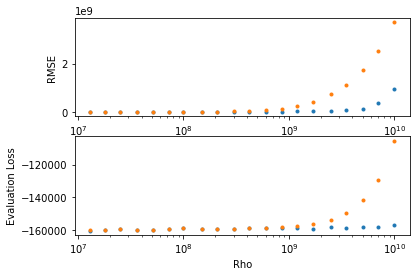

In [48]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(rho_dtime, RMSE_dtime_lst, '.', label='deadtime')
ax1.plot(rho_pois, RMSE_pois_lst, '.', label='poisson')
ax2.plot(rho_dtime, eval_loss_dtime, '.', label='deadtime')
ax2.plot(rho_pois, eval_loss_pois, '.', label='poisson')
ax1.set_xlabel('Rho')
ax1.set_ylabel('RMSE')
ax2.set_xlabel('Rho')
ax2.set_ylabel('Evaluation Loss')
ax1.set_xscale('log')
ax2.set_xscale('log')
plt.show()

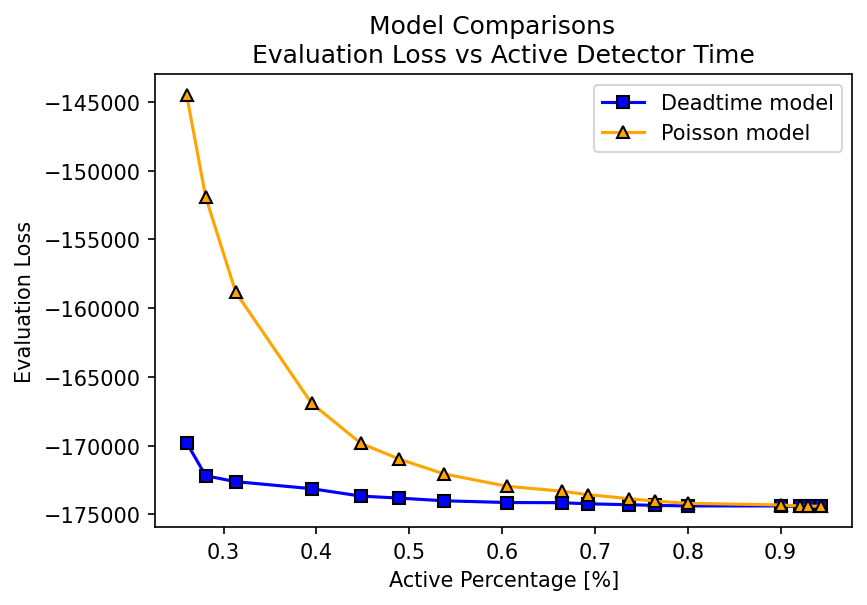

In [13]:
# Plot Eval Loss vs Average Active-Detector Percentage
skip_num = 0

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.plot(percent_active[skip_num:], eval_loss_dtime[skip_num:], 's-', color='blue', markeredgecolor='black', label='Deadtime model')
ax.plot(percent_active[skip_num:], eval_loss_pois[skip_num:], '^-', color='orange', markeredgecolor='black', label='Poisson model')
ax.set_xlabel('Active Percentage [%]')
ax.set_ylabel('Evaluation Loss')
plt.suptitle('Model Comparisons')
plt.title('Evaluation Loss vs Active Detector Time')
plt.legend()
# plt.xlim([0.5, 1.0])
# plt.ylim([-294000, -287000])
plt.show()

# Exploring shot scarcity dimension

In [12]:
num_shot_dead

array([2.50e+02, 3.75e+02, 5.00e+02, 7.50e+02, 1.00e+03, 5.00e+03,
       1.00e+04, 2.50e+04, 5.00e+04, 7.50e+04, 1.00e+05, 2.50e+05,
       5.00e+05])

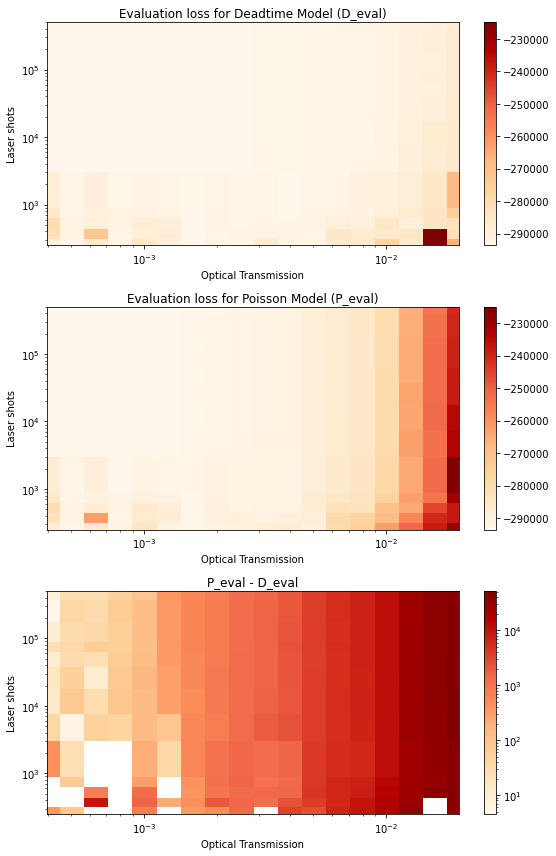

In [10]:
from matplotlib.colors import LogNorm

load_dir = r'C:\Users\Grant\OneDrive - UCB-O365\ARSENL\Experiments\SPCM\evaluation_loss\heatmap_iter_spread\Deadtime'
eval_loss_dtime_dead = []
num_shot_dead = []
for file in os.listdir(load_dir):
    if file.endswith('.csv'):
        df_dtime = pd.read_csv(load_dir + r'/' + file)
        num_shot = float(file[-12:-4])
        eval_loss_dtime = df_dtime['Evaluation Loss'].dropna()
        
        num_shot_dead.append(num_shot)
        eval_loss_dtime_dead.append(-1*eval_loss_dtime)
        
load_dir = r'C:\Users\Grant\OneDrive - UCB-O365\ARSENL\Experiments\SPCM\evaluation_loss\heatmap_iter_spread\Poisson'
eval_loss_dtime_pois = []
num_shot_pois = []
for file in os.listdir(load_dir):
    if file.endswith('.csv'):
        df_dtime = pd.read_csv(load_dir + r'/' + file)
        num_shot = float(file[-12:-4])
        OD = df_dtime['OD'][2:-1]
        eval_loss_dtime = df_dtime['Evaluation Loss'].dropna()
        
        num_shot_pois.append(num_shot)
        eval_loss_dtime_pois.append(-1*eval_loss_dtime)
        
reorder_dead = np.argsort(num_shot_dead).astype(int)
reorder_pois = np.argsort(num_shot_pois).astype(int)

num_shot_dead = np.array(num_shot_dead)[reorder_dead]
num_shot_pois = np.array(num_shot_pois)[reorder_pois]
eval_loss_dtime_dead = np.array(eval_loss_dtime_dead)[reorder_dead][:, 2:-1]
eval_loss_dtime_pois = np.array(eval_loss_dtime_pois)[reorder_pois][:, 2:-1]

transmit_factor = 10**(-OD)

# print(transmit_factor[2:-1])
# print(eval_loss_dtime_dead[:, 2:-1])

fig = plt.figure(figsize=(8,12))
ax1 = fig.add_subplot(311)
c = ax1.pcolormesh(transmit_factor, num_shot_dead, -1*eval_loss_dtime_dead, cmap='OrRd', vmin=-1*eval_loss_dtime_pois.max(), vmax=-1*eval_loss_dtime_pois.min())
ax1.axis([transmit_factor.min(), transmit_factor.max(), min(num_shot_dead), max(num_shot_dead)])
ax1.set_ylabel('Laser shots')
ax1.set_xlabel('Optical Transmission')
ax1.set_title('Evaluation loss for Deadtime Model (D_eval)')
ax1.set_yscale('log')
ax1.set_xscale('log')
fig.colorbar(c, ax=ax1)

ax2 = fig.add_subplot(312)
c = ax2.pcolormesh(transmit_factor, num_shot_pois, -1*eval_loss_dtime_pois, cmap='OrRd', vmin=-1*eval_loss_dtime_pois.max(), vmax=-1*eval_loss_dtime_pois.min())
ax2.axis([transmit_factor.min(), transmit_factor.max(), min(num_shot_pois), max(num_shot_pois)])
ax2.set_ylabel('Laser shots')
ax2.set_xlabel('Optical Transmission')
ax2.set_title('Evaluation loss for Poisson Model (P_eval)')
ax2.set_yscale('log')
ax2.set_xscale('log')
fig.colorbar(c, ax=ax2)

ax3 = fig.add_subplot(313)
c = ax3.pcolormesh(transmit_factor, num_shot_dead, (eval_loss_dtime_dead-eval_loss_dtime_pois), norm=LogNorm(), cmap='OrRd')
ax3.axis([transmit_factor.min(), transmit_factor.max(), min(num_shot_pois), max(num_shot_pois)])
ax3.set_ylabel('Laser shots')
ax3.set_xlabel('Optical Transmission')
ax3.set_title("P_eval - D_eval")
ax3.set_yscale('log')
ax3.set_xscale('log')
fig.colorbar(c, ax=ax3)

save_dir = r'C:/Users/Grant/Downloads'
save_plt_file = r'/pois_vs_dtime_eval_loss.png'
fig.savefig(save_dir + save_plt_file)
plt.tight_layout()
plt.show()


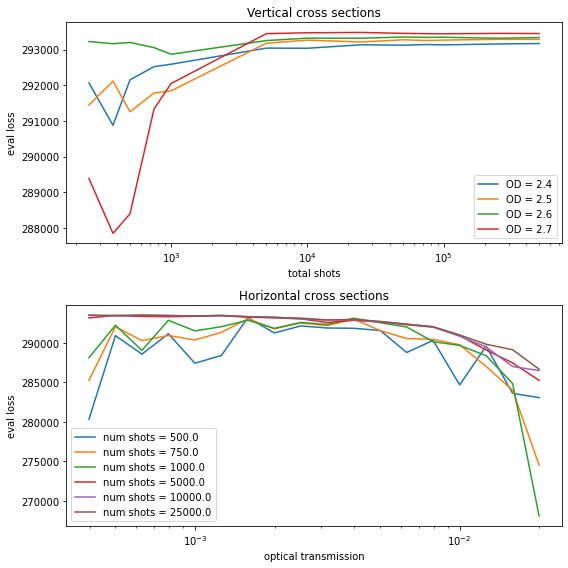

In [55]:
idx = np.arange(9, 13)

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
for i in idx:
    ax1.semilogx(num_shot_dead, eval_loss_dtime_dead[:, i], label='OD = {}'.format(OD[i]))
ax1.set_xlabel('total shots')
ax1.set_ylabel('eval loss')
ax1.set_title('Vertical cross sections')
ax1.legend()

idx = np.arange(2, 8)
ax2 = fig.add_subplot(212)
for i in idx:
    ax2.semilogx(transmit_factor, eval_loss_dtime_dead[i, :], label='num shots = {}'.format(num_shot_dead[i]))
ax2.set_xlabel('optical transmission')
ax2.set_ylabel('eval loss')
ax2.set_title('Horizontal cross sections')
ax2.legend()
plt.tight_layout()
plt.show()

# eval_loss_dtime_pois[:, 0]

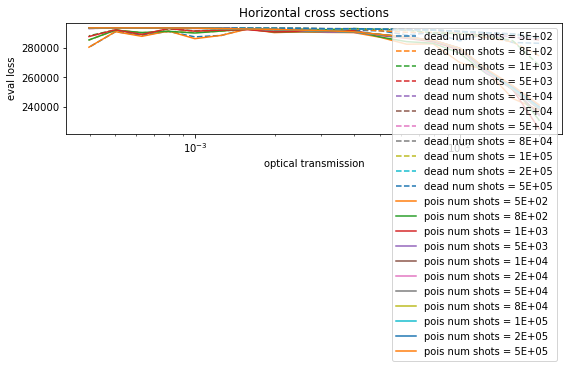

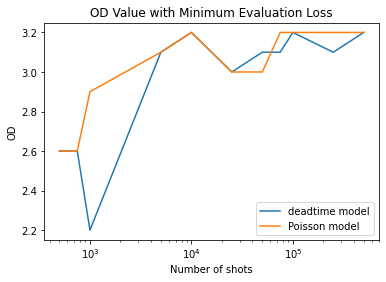

In [89]:
idx = np.arange(2, 13)
min_idx_eval_dead = np.zeros(len(idx))
min_idx_eval_pois = np.zeros(len(idx))

fig = plt.figure(figsize=(8,4))
ax2 = fig.add_subplot(111)
for i in range(len(idx)):
    ax2.semilogx(transmit_factor, eval_loss_dtime_dead[idx[i], :], '--', label='dead num shots = {:.0E}'.format(num_shot_dead[idx[i]]))
    min_idx_eval_dead[i] = np.argmin(-1*eval_loss_dtime_dead[idx[i], :])
for i in range(len(idx)):
    ax2.semilogx(transmit_factor, eval_loss_dtime_pois[idx[i], :], '-', label='pois num shots = {:.0E}'.format(num_shot_dead[idx[i]]))
    min_idx_eval_pois[i] = np.argmin(-1*eval_loss_dtime_pois[idx[i], :])
ax2.set_xlabel('optical transmission')
ax2.set_ylabel('eval loss')
ax2.set_title('Horizontal cross sections')
ax2.legend()
plt.tight_layout()
plt.show()

# print(min_idx_eval_dead)

fig = plt.figure()
ax4 = fig.add_subplot(111)
ax4.semilogx(num_shot_dead[idx], OD[min_idx_eval_dead], label='deadtime model')
ax4.semilogx(num_shot_dead[idx], OD[min_idx_eval_pois], label='Poisson model')
ax4.set_xlabel('Number of shots')
ax4.set_ylabel('OD')
ax4.set_title('OD Value with Minimum Evaluation Loss')
plt.legend()
plt.show()

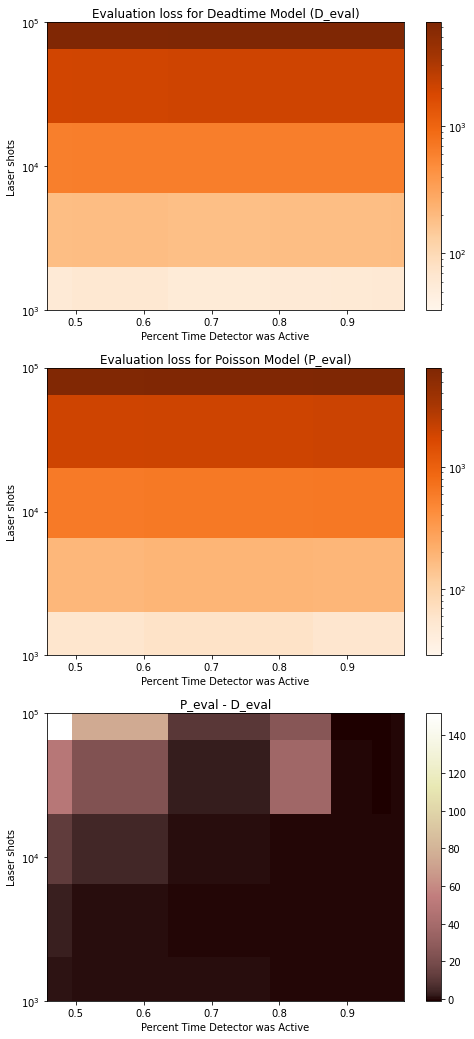

In [21]:
from matplotlib.colors import LogNorm

load_dir = r'C:\Users\Grant\OneDrive - UCB-O365\ARSENL\Experiments\Deadtime_Experiments\Figures\evaluation_loss\iter_num_shots_test2'
files = []
eval_loss_dtime_full = []
num_shot_full = []
for file in os.listdir(load_dir):
    if file.endswith('.csv'):
        files.append(r'/'+file)
        df_dtime = pd.read_csv(load_dir + r'/'+file)
        num_shot = float(file[-9:-4])
        OD = df_dtime['OD'][:-1]
        eval_loss_dtime = df_dtime['Evaluation Loss'].dropna()
        percent_active = df_dtime['Average %-age where Detector was Active'].dropna()
        optimal_C = df_dtime['Optimal Scaling Factor'].dropna()
        OD_C = df_dtime['Hypothetical Scaling Factor'][:-1]
        
        num_shot_full.append(num_shot)
        eval_loss_dtime_full.append(eval_loss_dtime)
        
max_lsr_num_lst = np.floor(np.logspace(3, 7, 16)).astype(int)[:-4]

reorder = np.argsort(num_shot_full).astype(int)
num_shot_full = np.array(num_shot_full)[reorder]
eval_loss_dtime_full = np.array(eval_loss_dtime_full)[reorder]
eval_loss_dtime_dead = -1*eval_loss_dtime_full[1::2]
num_shot_dead = num_shot_full[1::2]
eval_loss_dtime_pois = -1*eval_loss_dtime_full[0::2]
num_shot_pois = num_shot_full[0::2]

# print(eval_loss_dtime_full)

fig = plt.figure(figsize=(8,18))
ax1 = fig.add_subplot(311)
c = ax1.pcolormesh(percent_active[2:], num_shot_dead, eval_loss_dtime_dead[:, 2:], norm=LogNorm(eval_loss_dtime_dead.min(), eval_loss_dtime_dead.max()), cmap='Oranges')
ax1.axis([percent_active[2:].min(), percent_active.max(), min(num_shot_dead), max(num_shot_dead)])
ax1.set_ylabel('Laser shots')
ax1.set_xlabel('Percent Time Detector was Active')
ax1.set_title('Evaluation loss for Deadtime Model (D_eval)')
ax1.set_yscale('symlog')
fig.colorbar(c, ax=ax1)

ax2 = fig.add_subplot(312)
c = ax2.pcolormesh(OD[2:], num_shot_pois, eval_loss_dtime_pois[:, 2:], norm=LogNorm(eval_loss_dtime_pois.min(), eval_loss_dtime_pois.max()), cmap='Oranges')
ax2.axis([percent_active[2:].min(), percent_active.max(), min(num_shot_pois), max(num_shot_pois)])
ax2.set_ylabel('Laser shots')
ax2.set_xlabel('Percent Time Detector was Active')
ax2.set_title('Evaluation loss for Poisson Model (P_eval)')
ax2.set_yscale('symlog')
fig.colorbar(c, ax=ax2)

ax3 = fig.add_subplot(313)
c = ax3.pcolormesh(percent_active[2:], num_shot_dead, (eval_loss_dtime_dead-eval_loss_dtime_pois)[:, 2:], cmap='pink')
ax3.axis([percent_active[2:].min(), percent_active.max(), min(num_shot_dead), max(num_shot_dead)])
ax3.set_ylabel('Laser shots')
ax3.set_xlabel('Percent Time Detector was Active')
ax3.set_title("P_eval - D_eval")
ax3.set_yscale('symlog')
fig.colorbar(c, ax=ax3)

# ax2 = fig.add_subplot(212, projection='3d')
# xv_dead, yv_dead = np.meshgrid(OD, np.log10(num_shot_dead), indexing='ij')
# xv_pois, yv_pois = np.meshgrid(OD, np.log10(num_shot_pois), indexing='ij')
# ax2.scatter(xv_dead[2:, :], yv_dead[2:, :], eval_loss_dtime_dead.T[2:, :], c='green', label='Deadtime model')
# ax2.scatter(xv_pois[2:, :], yv_pois[2:, :], eval_loss_dtime_pois.T[2:, :], c='blue', label='Poisson model')
# ax2.set_xlabel('OD')
# ax2.set_ylabel('log10(Laser shots)')
# ax2.set_zlabel('Evaluation Loss')
# ax2.set_yscale('symlog')
# # ax2.set_xlim([OD.min(), OD.max()])
# plt.legend()

plt.show()


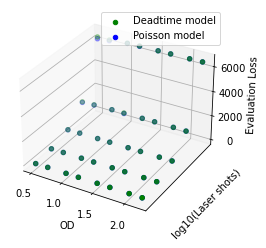

In [22]:
fig = plt.figure()
ax2 = fig.add_subplot(111, projection='3d')
xv_dead, yv_dead = np.meshgrid(OD, np.log10(num_shot_dead), indexing='ij')
xv_pois, yv_pois = np.meshgrid(OD, np.log10(num_shot_pois), indexing='ij')
ax2.scatter(xv_dead[2:, :], yv_dead[2:, :], eval_loss_dtime_dead.T[2:, :], c='green', label='Deadtime model')
ax2.scatter(xv_pois[2:, :], yv_pois[2:, :], eval_loss_dtime_pois.T[2:, :], c='blue', label='Poisson model')
ax2.set_xlabel('OD')
ax2.set_ylabel('log10(Laser shots)')
ax2.set_zlabel('Evaluation Loss')
ax2.set_yscale('symlog')
# ax2.set_xlim([OD.min(), OD.max()])
plt.legend()

plt.show()

# Graveyard

In [ ]:
# Plot scaling factors vs Average Active-Detector Percentage

# fig = plt.figure(figsize=(12,8))
# ax1 = fig.add_subplot(121)
# ax1.plot(percent_active, optimal_C, 'b.', label='Optimal Scaling Factor')
# ax1.plot(percent_active, OD_C, 'm.', label='Scaling Factor based on OD')
# ax1.set_xlabel('Active Percentage')
# ax1.set_ylabel('Scaling Factor')
# ax2 = fig.add_subplot(122)
# ax2.plot(percent_active, OD_C/optimal_C, 'b.', label='Optimal Scaling Factor')
# ax2.set_xlabel('Active Percentage')
# ax2.set_ylabel('Ratio of Scaling Factors (Hypothetical/Optimal)')
# plt.suptitle('Scaling Factor Comparisons')
# ax1.legend()
# plt.show()